# Time series forecasting

This notebook adapts the Tensorflow tutorial on [Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series) to data generated from a model for epidemic processes. 

## Steps

1. Imports and setup
2. Load and prepare the generated data
3. Baseline forecasting
4. Univariate LSTM based forecasting
5. Multivariate LSTM based forecasting - Single Step
6. Multivariate LSTM based forecasting - Multiple Steps

## Imports and setup

In [127]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Load and prepare the generated data

We load data from the ODE model introduced in the notebook "Probability and Information Theory". For each of the 150 virtuel outbreaks (randomized and with different model parameters), we have time series (with 500 steps) for four the variables "Susceptible", "Infected", "Recovered", and "Deceased".

In [128]:
csv_path = "./data/epidemic_process_raw_data.csv"
df = pd.read_csv(csv_path)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
0,100.287149,103.541223,95.879814,96.354848,96.980932,97.855310,98.940537,100.187494,98.265709,95.307794,...,4.925236,4.922108,4.918981,4.915853,4.912726,4.950240,4.995291,5.040342,5.085393,5.130445
1,0.993774,1.017558,1.070030,1.116168,1.142078,1.134735,1.182418,1.272310,1.356565,1.438978,...,0.391775,0.384359,0.376942,0.369526,0.362109,0.356669,0.351595,0.346521,0.341447,0.336374
2,0.000000,0.017741,0.036585,0.054735,0.074266,0.096065,0.117691,0.139184,0.163615,0.189006,...,97.247764,96.062916,94.878068,93.693219,92.508371,92.617122,92.965783,93.314443,93.663103,94.011764
3,0.000000,0.000178,0.000364,0.000562,0.000757,0.000947,0.001160,0.001389,0.001635,0.001887,...,0.947347,0.950713,0.954079,0.957445,0.960811,0.959320,0.956929,0.954537,0.952146,0.949755
4,103.489688,100.282780,96.634270,98.532514,99.089272,97.440900,98.416534,101.404903,100.480758,98.277282,...,2.071958,2.064501,2.072213,2.090890,2.109567,2.128244,2.146921,2.165597,2.184274,2.202951


In [129]:
dfSusceptible = df[df.index % 4 == 0]
dfSusceptible.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
0,100.287149,103.541223,95.879814,96.354848,96.980932,97.855310,98.940537,100.187494,98.265709,95.307794,...,4.925236,4.922108,4.918981,4.915853,4.912726,4.950240,4.995291,5.040342,5.085393,5.130445
4,103.489688,100.282780,96.634270,98.532514,99.089272,97.440900,98.416534,101.404903,100.480758,98.277282,...,2.071958,2.064501,2.072213,2.090890,2.109567,2.128244,2.146921,2.165597,2.184274,2.202951
8,101.527421,97.711732,96.168179,95.677962,95.575326,96.109792,96.943831,98.007655,98.132798,97.951008,...,48.629414,48.662862,48.696309,48.729757,48.763204,48.796652,48.830099,48.863547,48.896994,48.930442
12,101.061107,99.112815,106.651686,101.622904,97.726686,95.692173,97.438263,102.084252,101.831030,99.975843,...,3.890526,3.869629,3.894123,3.928628,3.963133,3.997638,4.032143,4.066648,4.101153,4.135658
16,101.957189,101.898022,100.881113,99.892000,98.939878,98.048565,98.220024,99.206678,99.067041,98.559123,...,5.878943,5.910111,5.941279,5.959441,5.860292,5.761142,5.667567,5.680109,5.692651,5.705193


In [130]:
dfInfected = df[df.index % 4 == 1]
dfInfected.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
1,0.993774,1.017558,1.070030,1.116168,1.142078,1.134735,1.182418,1.272310,1.356565,1.438978,...,0.391775,0.384359,0.376942,0.369526,0.362109,0.356669,0.351595,0.346521,0.341447,0.336374
5,1.021677,1.045410,1.120324,1.175914,1.236878,1.306676,1.387931,1.477973,1.549873,1.615840,...,0.172933,0.171653,0.169739,0.167366,0.164993,0.162620,0.160247,0.157874,0.155501,0.153128
9,1.020043,1.011238,1.031122,1.048642,1.049479,1.022891,1.035862,1.079177,1.114531,1.147282,...,5.658505,5.625406,5.592308,5.559209,5.526111,5.493012,5.459914,5.426815,5.393717,5.360619
13,1.035248,1.014189,1.133178,1.135622,1.157984,1.213088,1.281406,1.359858,1.423234,1.481680,...,0.297238,0.292756,0.288433,0.284145,0.279857,0.275569,0.271280,0.266992,0.262704,0.258416
17,1.012666,1.016949,1.053194,1.097599,1.143640,1.192369,1.238880,1.283688,1.324305,1.363552,...,0.475822,0.467301,0.458779,0.450518,0.444609,0.438701,0.432715,0.425247,0.417780,0.410313


In [131]:
dfRecovered = df[df.index % 4 == 2]
dfRecovered.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
2,0.0,0.017741,0.036585,0.054735,0.074266,0.096065,0.117691,0.139184,0.163615,0.189006,...,97.247764,96.062916,94.878068,93.693219,92.508371,92.617122,92.965783,93.314443,93.663103,94.011764
6,0.0,0.017909,0.035748,0.056118,0.076620,0.097338,0.119592,0.143024,0.171253,0.201050,...,96.481711,97.126839,97.050590,96.452872,95.855153,95.257435,94.659716,94.061998,93.464279,92.866561
10,0.0,0.016990,0.034644,0.052866,0.071444,0.090609,0.108733,0.126058,0.142408,0.158437,...,45.237808,45.424013,45.610219,45.796424,45.982629,46.168835,46.355040,46.541246,46.727451,46.913657
14,0.0,0.017002,0.036315,0.057484,0.078381,0.098831,0.119563,0.140509,0.166486,0.194109,...,92.875601,92.371850,92.874094,93.598211,94.322327,95.046444,95.770560,96.494677,97.218794,97.942910
18,0.0,0.017589,0.037434,0.056572,0.076275,0.096907,0.116533,0.135387,0.157592,0.180893,...,93.437562,93.064191,92.690821,92.516054,94.132580,95.749106,97.237129,96.278611,95.320093,94.361575


In [132]:
dfDead = df[df.index % 4 == 3]
dfDead.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
3,0.0,0.000178,0.000364,0.000562,0.000757,0.000947,0.001160,0.001389,0.001635,0.001887,...,0.947347,0.950713,0.954079,0.957445,0.960811,0.959320,0.956929,0.954537,0.952146,0.949755
7,0.0,0.000175,0.000351,0.000558,0.000763,0.000968,0.001196,0.001443,0.001719,0.002004,...,0.989016,0.987952,0.986532,0.984855,0.983178,0.981502,0.979825,0.978148,0.976471,0.974794
11,0.0,0.000171,0.000352,0.000538,0.000729,0.000927,0.001126,0.001324,0.001488,0.001642,...,0.454590,0.455255,0.455920,0.456585,0.457250,0.457914,0.458579,0.459244,0.459909,0.460574
15,0.0,0.000181,0.000364,0.000563,0.000774,0.001003,0.001192,0.001351,0.001575,0.001822,...,0.951079,0.954145,0.954334,0.953888,0.953443,0.952997,0.952552,0.952106,0.951661,0.951215
19,0.0,0.000180,0.000358,0.000550,0.000740,0.000931,0.001138,0.001359,0.001574,0.001787,...,0.975329,0.959467,0.943605,0.929243,0.928406,0.927568,0.927127,0.934226,0.941326,0.948426


Below a plot of three infection time series for the three first outbreaks.

In [133]:
print(dfSusceptible.loc[0][np.argmax(dfInfected.loc[1])])
print(np.argmax(dfInfected.loc[1]), dfInfected.loc[1][np.argmax(dfInfected.loc[1])])
print(dfRecovered.loc[2][np.argmax(dfInfected.loc[1])])
print(dfDead.loc[3][np.argmax(dfInfected.loc[1])])
# dfInfected.loc[1,:].plot()
# dfInfected.loc[5,:].plot()
# dfInfected.loc[9,:].plot()

32.7035320395393
143 33.9124768491609
35.9719802979143
0.351581606839808


In [134]:
# convert pandas to np
npInfected = dfInfected.to_numpy()
npSusceptible = dfSusceptible.to_numpy()
npRecovered = dfRecovered.to_numpy()
npDead = dfDead.to_numpy()

# Find height of infection for each outbreak
argmax = np.argmax(npInfected,axis=1)

# Get the quickest rise
amin = np.amin(np.argmax(npInfected,axis=1))

# Calculate "center" using difference between num days to quickest rise and each outbreak's peak
centered = -1*(argmax - amin)

# Shift each outbreak to the left (and around) so the peak days are aligned to the beginning of the matrix
npInfectedShifted = np.zeros(npInfected.shape)
npSusceptibleShifted = np.zeros(npInfected.shape)
npRecoveredShifted = np.zeros(npInfected.shape)
npDeadShifted = np.zeros(npInfected.shape)

for row in range(shifted.shape[0]):
    # Get num spaces to roll by for each of the matrices
    centeredrow = centered[row]
    
    thisrow = npInfected[row,:]
    npInfectedShifted[row,:] = np.roll(thisrow,centeredrow)
    
    thisrow = npSusceptible[row,:]
    npSusceptibleShifted[row,:] = np.roll(thisrow, centeredrow)
    
    thisrow = npRecovered[row,:]
    npRecoveredShifted[row,:] = np.roll(thisrow, centeredrow)
    
    thisrow = npDead[row,:]
    npDeadShifted[row,:] = np.roll(thisrow, centeredrow)
    
# print(centered)

# print(npInfected[9,0])
# print(npInfectedShifted[9,-17])

# print(npSusceptible[9,0])
# print(npSusceptibleShifted[9,-17])

# print(npRecovered[9,0])
# print(npRecoveredShifted[9,-17])

# print(npDead[9,0])
# print(npDeadShifted[9,-17])


We define a 90% / 10% of data for training / testing.

In [137]:
dfInfected_arr = npInfectedShifted#dfInfected.values
dfInfected_arr.shape
TRAIN_SPLIT = int(dfInfected_arr.shape[0]-dfInfected_arr.shape[0]*0.1)
TRAIN_SPLIT

135

We standardize the data.

In [138]:
uni_train_mean = dfInfected_arr[:TRAIN_SPLIT].mean()
uni_train_std = dfInfected_arr[:TRAIN_SPLIT].std()
uni_data = (dfInfected_arr-uni_train_mean)/uni_train_std
print ('\n Univariate data shape')
print(uni_data.shape)


 Univariate data shape
(150, 501)


We split the data into time series of `univariate_past_history=20` days length and predict the future of the current day, i.e., `univariate_future_target=0`, for the "infected" variable. 

In [139]:
def univariate_data(dataset, start_series, end_series, history_size, target_size):
    data = []
    labels = []
    start_index = history_size
    end_index = len(dataset[0]) - target_size   
    for c in range(start_series, end_series):
        for i in range(start_index, end_index):
            indices = range(i-history_size, i)
            # Reshape data from (history_size,) to (history_size, 1)
            data.append(np.reshape(dataset[c][indices], (history_size, 1)))
            labels.append(dataset[c][i+target_size])
    return np.array(data), np.array(labels)

In [140]:
univariate_past_history = 20 #days
univariate_future_target = 0 #current day

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, len(uni_data),
                                       univariate_past_history,
                                       univariate_future_target)

In [141]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target number to predict')
print (y_train_uni[0])
print ('\n Number of traing data points')
print (y_train_uni.shape[0])
print ('\n Number of test data points')
print (x_val_uni.shape[0])

Single window of past history
[[-0.2478082 ]
 [-0.22484622]
 [-0.20188425]
 [-0.17892228]
 [-0.1559603 ]
 [-0.13299833]
 [-0.11003636]
 [-0.0801657 ]
 [-0.04866735]
 [-0.017169  ]
 [ 0.01432935]
 [ 0.04582769]
 [ 0.07732604]
 [ 0.10882439]
 [ 0.14032274]
 [ 0.172603  ]
 [ 0.20579935]
 [ 0.2389957 ]
 [ 0.27219205]
 [ 0.3053884 ]]

 Target number to predict
0.33858475007280786

 Number of traing data points
64935

 Number of test data points
7215


In [142]:
def create_time_steps(length):
    return list(range(-length, 0))

In [143]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/Library/www/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

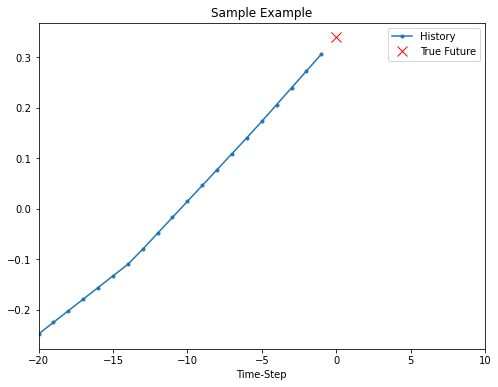

In [144]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

## Baseline forecasting

Predicts the mean of the `history`.

In [145]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/Library/www/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

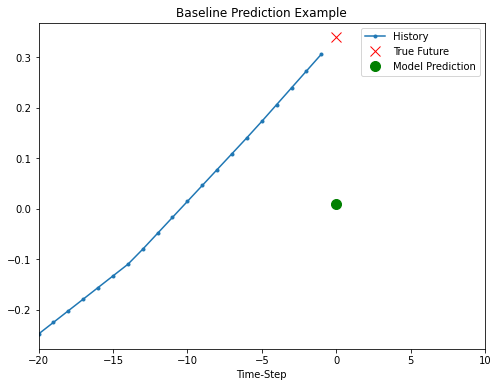

In [146]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

## Univariate LSTM based forecasting

In [147]:
print (x_train_uni.shape)
print (y_train_uni.shape)
x_train_uni.dtype

(64935, 20, 1)
(64935,)


dtype('float64')

Batching and resampling; the dataset is repeated indefinitely. Check the tutorial for the details.

In [19]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

train_univariate

<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>

We define the first LSTM model with 8 units.

In [30]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8)#, input_shape=x_train_uni.shape[-2:])
#     tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
# simple_lstm_model.summary()
# x_train_uni.shape[-2:]

In [31]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)
    print(y.shape)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



NotImplementedError: in user code:

    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:386 call
        outputs = layer(inputs, **kwargs)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:659 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent_v2.py:1108 call
        inputs, initial_state, _ = self._process_inputs(inputs, initial_state, None)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:858 _process_inputs
        initial_state = self.get_initial_state(inputs)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:642 get_initial_state
        inputs=None, batch_size=batch_size, dtype=dtype)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:2520 get_initial_state
        self, inputs, batch_size, dtype))
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:2964 _generate_zero_filled_state_for_cell
        return _generate_zero_filled_state(batch_size, cell.state_size, dtype)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:2980 _generate_zero_filled_state
        return nest.map_structure(create_zeros, state_size)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/nest.py:635 map_structure
        structure[0], [func(*x) for x in entries],
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/nest.py:635 <listcomp>
        structure[0], [func(*x) for x in entries],
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:2977 create_zeros
        return array_ops.zeros(init_state_size, dtype=dtype)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:2747 wrapped
        tensor = fun(*args, **kwargs)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:2794 zeros
        output = _constant_if_small(zero, shape, dtype, name)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:2732 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:6 prod
        
    /Library/www/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3031 prod
        keepdims=keepdims, initial=initial, where=where)
    /Library/www/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    /Library/www/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:848 __array__
        " a NumPy call, which is not supported".format(self.name))

    NotImplementedError: Cannot convert a symbolic Tensor (sequential_8/lstm_8/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


When passing an indefinitely repeated training data set, we need to specify the numbre of steps per training interval (epoch).

In [ ]:
EVALUATION_INTERVAL = 2000
EPOCHS = 10

simple_lstm_model.fit(train_univariate, 
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, 
                      validation_steps=50)

In [ ]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

## Multivariate LSTM based forecasting - Single Step

We use three variables "Infected", "Recovered", and "Deceased", to forcast "Infected" at one single day in the future.

Here a plot of the time series of the three variables for one outbreak. 

In [ ]:
dfInfected.loc[1,:].plot()
dfRecovered.loc[2,:].plot()
dfDead.loc[3,:].plot()
dfInfected = dfInfected.values
dfRecovered_arr = dfRecovered.values
dfDead_arr = dfDead.values

We prepare the dataset.

In [ ]:
#as before
dfInfected_train_mean = dfInfected_arr[:TRAIN_SPLIT].mean()
dfInfected_train_std = dfInfected_arr[:TRAIN_SPLIT].std()
dfInfected_data = (dfInfected_arr-dfInfected_train_mean)/dfInfected_train_std
#for Recovered
dfRecovered_train_mean = dfRecovered_arr[:TRAIN_SPLIT].mean()
dfRecovered_train_std = dfRecovered_arr[:TRAIN_SPLIT].std()
dfRecovered_data = (dfRecovered_arr-dfRecovered_train_mean)/dfRecovered_train_std
#for Dead
dfDead_train_mean = dfDead_arr[:TRAIN_SPLIT].mean()
dfDead_train_std = dfDead_arr[:TRAIN_SPLIT].std()
dfDead_data = (dfDead_arr-dfDead_train_mean)/dfDead_train_std

In [ ]:
dataset = np.array([dfInfected_data, dfRecovered_data, dfDead_data])
dataset.shape
print ('\n Multivariate data shape')
print(dataset.shape)

In [ ]:
def multivariate_data(dataset, target, start_series, end_series, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    start_index = history_size
    end_index = len(dataset[0][0]) - target_size   
    for c in range(start_series, end_series):
        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            one = dataset[0][c][indices]
            two = dataset[1][c][indices]
            three = dataset[2][c][indices]
            data.append(np.transpose(np.array([one, two, three])))
            
            if single_step:
                labels.append(target[c][i+target_size])
            else:
                labels.append(np.transpose(target[c][i:i+target_size]))
    return np.array(data), np.array(labels)

We get training and valdation data for time series with a `past_history = 20` days for every other day (`STEP = 2`) and want to predict the "Infected" five days ahead (`future_target = 5`).

In [ ]:
past_history = 20
future_target = 5
STEP = 2

x_train_single, y_train_single = multivariate_data(dataset, dfInfected_data, 0, TRAIN_SPLIT, 
                                                   past_history, future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dfInfected_data, TRAIN_SPLIT, dataset.shape[1], 
                                               past_history, future_target, STEP,
                                               single_step=True)

In [ ]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print(dataset.shape)

As before, batching and resampling; the dataset is repeated indefinitely.

In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_model.summary()
x_train_single.shape[-2:]

In [ ]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)
print ('\n Number of traing data points')
print (x_train_single.shape[0])
print ('\n Number of test data points')
print (x_val_single.shape[0])

In [ ]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

In [ ]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
plot_train_history(single_step_history,'Single Step Training and validation loss')

In [ ]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], future_target,
                   'Single Step Prediction')
    plot.show()

## Multivariate LSTM - Multiple Steps

Still, we use a series of observed values of the three variables "Infected", "Recovered", and "Deceased" (`past_history = 40, STEP =2`), but now to forcast the "Infected" values for a series day in the future (`future_target = 10`).

In [ ]:
past_history = 40
future_target = 10
STEP =2
x_train_multi, y_train_multi = multivariate_data(dataset, dfInfected_data, 0, TRAIN_SPLIT, 
                                                    past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dfInfected_data, TRAIN_SPLIT, dataset.shape[1], 
                                                past_history, future_target, STEP)

In [ ]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\nTarget window to predict : {}'.format(y_train_multi[0].shape))
print ('\nNumber of traing data points: {}'.format(x_train_multi.shape[0]))
print ('\nNumber of test data points: {}'.format(x_val_multi.shape[0]))

As before, batching and resampling; the dataset is repeated indefinitely.

In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

Now we bild a model with two LSTM layers.

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
multi_step_model.summary()
x_train_multi.shape[-2:]

In [ ]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

The training time is longer for this more complex model.

In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [ ]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])